In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from collections import defaultdict

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#Import Dataset
df = pd.read_csv('Mode_Craft_Ecommerce_Data - Online_Retail.csv', dtype={'InvoiceNo': str}, low_memory=False)
df.index = pd.to_datetime(df.InvoiceDate)
df = df.dropna(how='all')
df.tail(10)

C:\Users\rajit\AppData\Local\Temp\ipykernel_10472\2999756280.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.InvoiceDate)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,,
2011-12-08 19:26:00,C581468,22098,BOUDOIR SQUARE TISSUE BOX,-12,12/8/11 19:26,0.39,13599.0,United Kingdom
2011-12-08 19:26:00,C581468,21314,SMALL GLASS HEART TRINKET POT,-10,12/8/11 19:26,2.10,13599.0,United Kingdom
2011-12-08 19:28:00,C581470,23084,RABBIT NIGHT LIGHT,-4,12/8/11 19:28,2.08,17924.0,United Kingdom
2011-12-09 09:27:00,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/11 9:27,2.08,16446.0,United Kingdom
2011-12-09 09:57:00,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,12/9/11 9:57,1.95,14397.0,United Kingdom
2011-12-09 09:57:00,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/11 9:57,0.83,14397.0,United Kingdom
2011-12-09 10:28:00,C581499,M,Manual,-1,12/9/11 10:28,224.69,15498.0,United Kingdom
2011-12-09 11:57:00,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/11 11:57,10.95,15311.0,United Kingdom
2011-12-09 11:58:00,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,12/9/11 11:58,1.25,17315.0,United Kingdom


In [3]:
#Create Columns
def create_features(df):
    """
    Create time series features based on time series index.
    Revenue (Quantity x Unit Price)
    Day of Week

    Weekday or Weekend
    Quarter
    Product Name 
    """
    df = df.copy()
    df['revenue'] = df['Quantity'] * df['UnitPrice']
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df.index.dayofweek >= 5
    df['InvoiceDate'] = df.index
    return df

df = create_features(df)

df.tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,dayofyear,quarter,is_weekend
InvoiceDate,,,,,,,,,,,,
2011-12-08 19:26:00,C581468,22098,BOUDOIR SQUARE TISSUE BOX,-12,2011-12-08 19:26:00,0.39,13599.0,United Kingdom,-4.68,342,4,False
2011-12-08 19:26:00,C581468,21314,SMALL GLASS HEART TRINKET POT,-10,2011-12-08 19:26:00,2.10,13599.0,United Kingdom,-21.00,342,4,False
2011-12-08 19:28:00,C581470,23084,RABBIT NIGHT LIGHT,-4,2011-12-08 19:28:00,2.08,17924.0,United Kingdom,-8.32,342,4,False
2011-12-09 09:27:00,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,-168469.60,343,4,False
2011-12-09 09:57:00,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom,-23.40,343,4,False
2011-12-09 09:57:00,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13,343,4,False
2011-12-09 10:28:00,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69,343,4,False
2011-12-09 11:57:00,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75,343,4,False
2011-12-09 11:58:00,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-6.25,343,4,False


In [4]:
#Cleaning

# Step 1: Remove rows with UnitPrice == 0
df = df[df['UnitPrice'] != 0]

# Step 2: Build cancel_map 
cancel_map = defaultdict(set)

for _, row in df.iterrows():
    invoice = (str)(row['InvoiceNo'])
    customer_id = row['CustomerID']
    if (invoice).startswith('C'):
        cancel_map[customer_id].add(row['StockCode'])

# Step 3: Remove rows where (InvoiceNo, StockCode) match the cancelled pair
def is_cancelled_pair(row):
    customer_id = row['CustomerID']
    stock = row['StockCode']
    return customer_id in cancel_map and stock in cancel_map[customer_id]

df = df[~df.apply(is_cancelled_pair, axis=1)]

# Step 4: Remove cancellation rows and InvoiceNo with "B"
df = df[~df['InvoiceNo'].str.startswith('C')]
df = df[~df['InvoiceNo'].str.contains('B', case=False)]
# 0.1% and 99.9% bounds
low_q = df['revenue'].quantile(0.00001)
high_q = df['revenue'].quantile(0.99999)

# Filter only extreme outliers
df = df[(df['revenue'] >= low_q) & (df['revenue'] <= high_q)]

df.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID,revenue,dayofyear,quarter
count,512110.000000,512110,512110.000000,379894.0000,512110.000000,512110.000000,512110.000000
mean,9.733180,2011-07-05 06:33:26.250805504,3.727179,15301.6116,18.278832,214.323784,2.842278
min,1.000000,2010-12-01 08:26:00,0.040000,12347.0000,0.060000,4.000000,1.000000
25%,1.000000,2011-03-28 12:49:00,1.250000,13975.0000,3.750000,126.000000,2.000000
50%,3.000000,2011-07-20 16:17:00,2.080000,15172.0000,9.780000,240.000000,3.000000
75%,10.000000,2011-10-20 10:41:00,4.130000,16806.0000,17.400000,312.000000,4.000000
max,4300.000000,2011-12-09 12:50:00,4287.630000,18287.0000,4401.000000,357.000000,4.000000
std,34.380603,NaN,19.237951,1711.5339,60.041627,106.231738,1.137279


<Axes: title={'center': 'Weekly Invoice vs Revenue'}, xlabel='week', ylabel='revenue'>

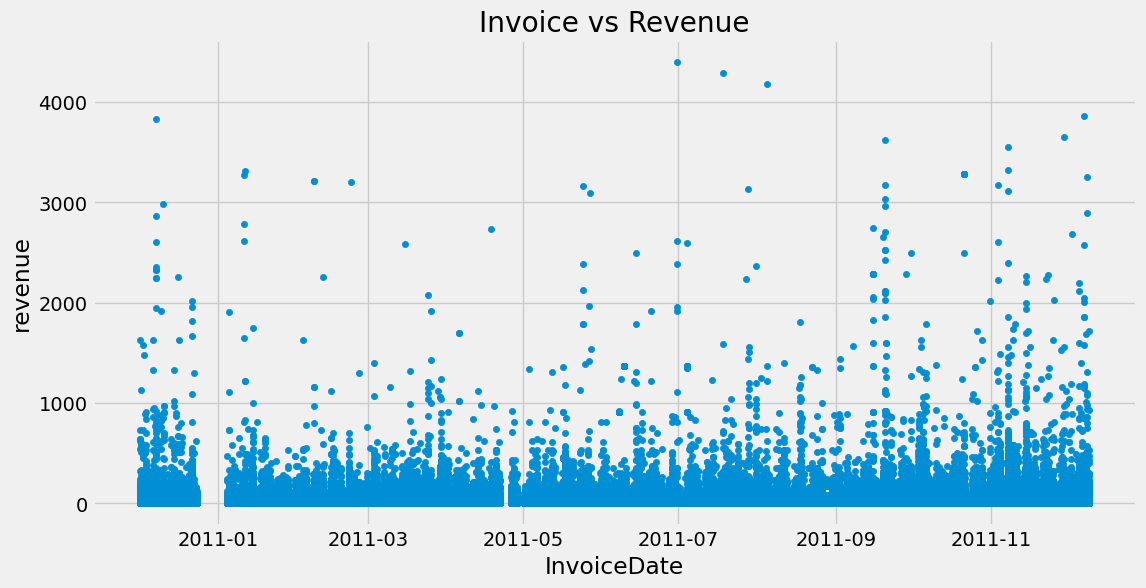

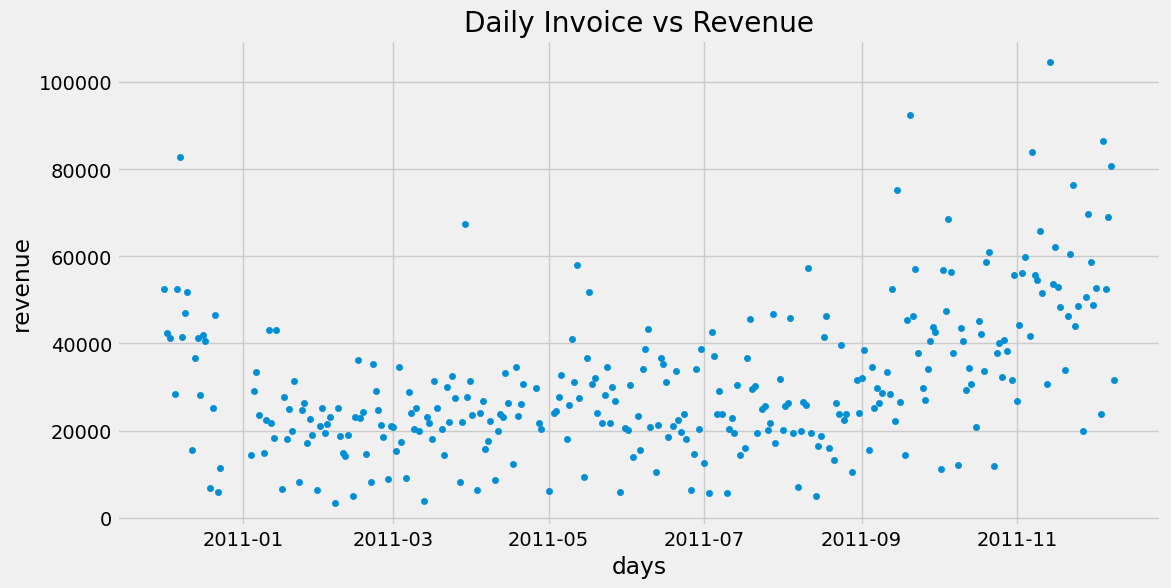

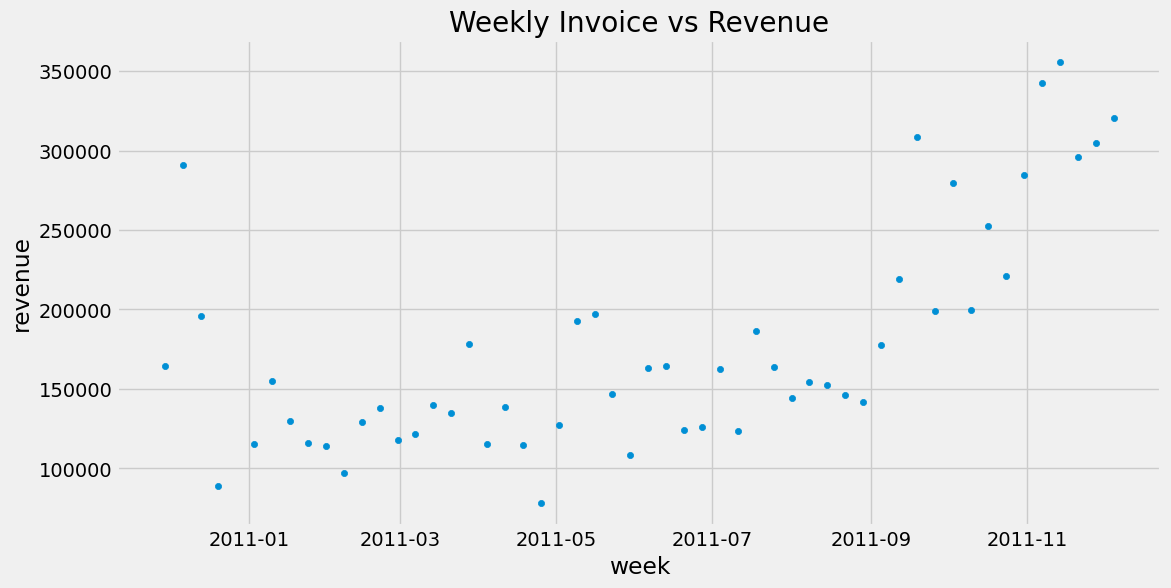

In [5]:
#New Dataframes

df.plot.scatter(x='InvoiceDate', y='revenue',title='Invoice vs Revenue', figsize=(12, 6))

df['days'] = df['InvoiceDate'].dt.date
daily_revenue_df = df.groupby('days')['revenue'].sum().reset_index()
daily_revenue_df.plot.scatter( x='days', y='revenue',title='Daily Invoice vs Revenue', figsize=(12, 6))

df['week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_revenue_df = df.groupby('week')['revenue'].sum().reset_index()
weekly_revenue_df.plot.scatter(x='week', y='revenue', title='Weekly Invoice vs Revenue', figsize=(12, 6))


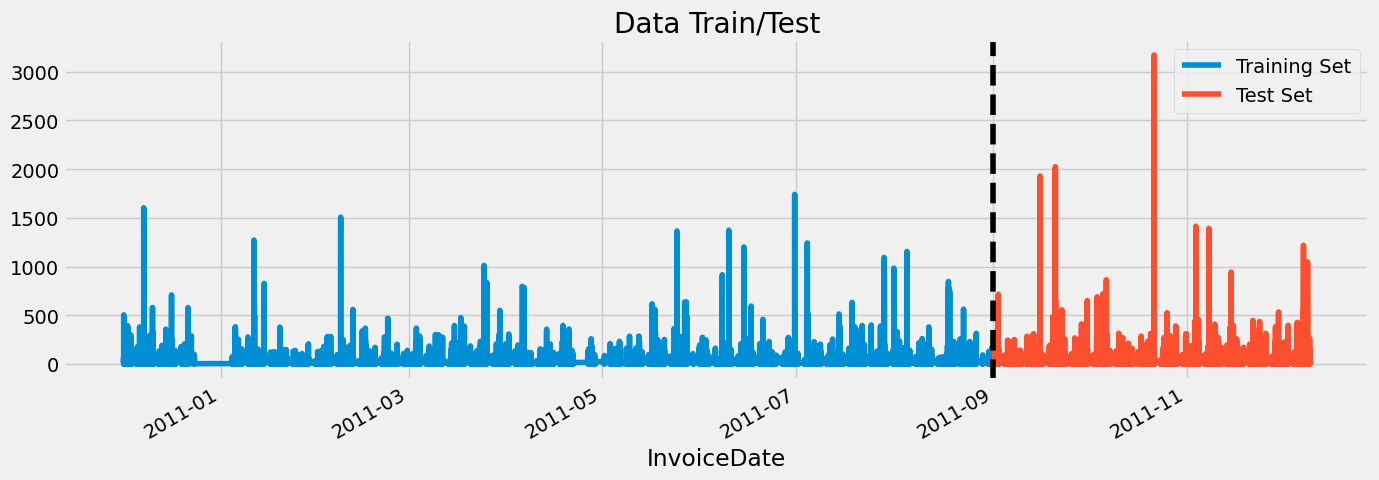

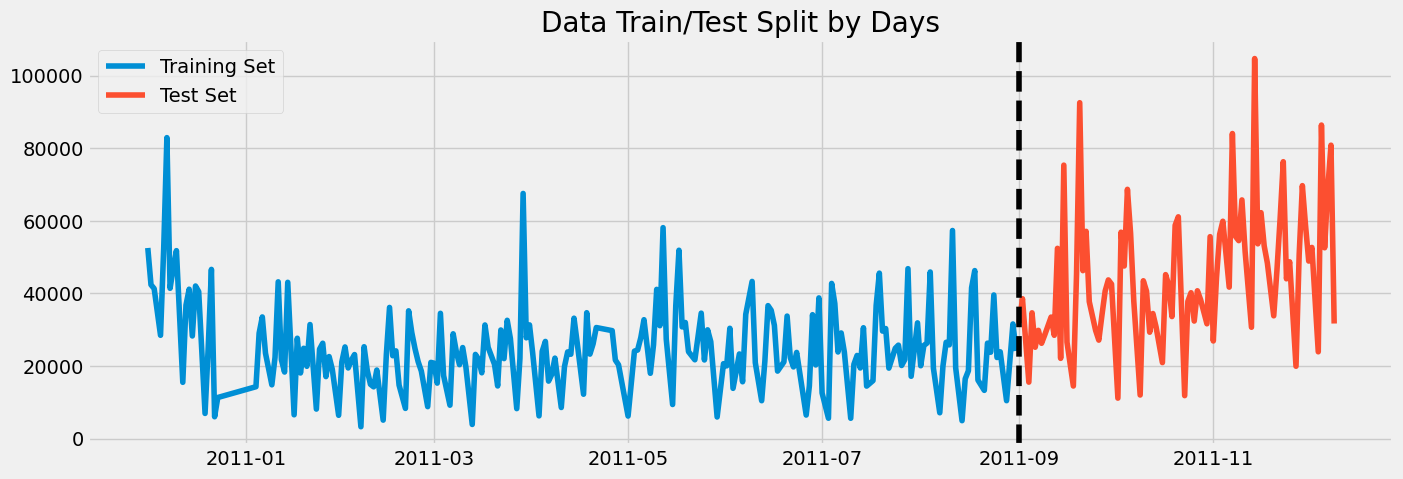

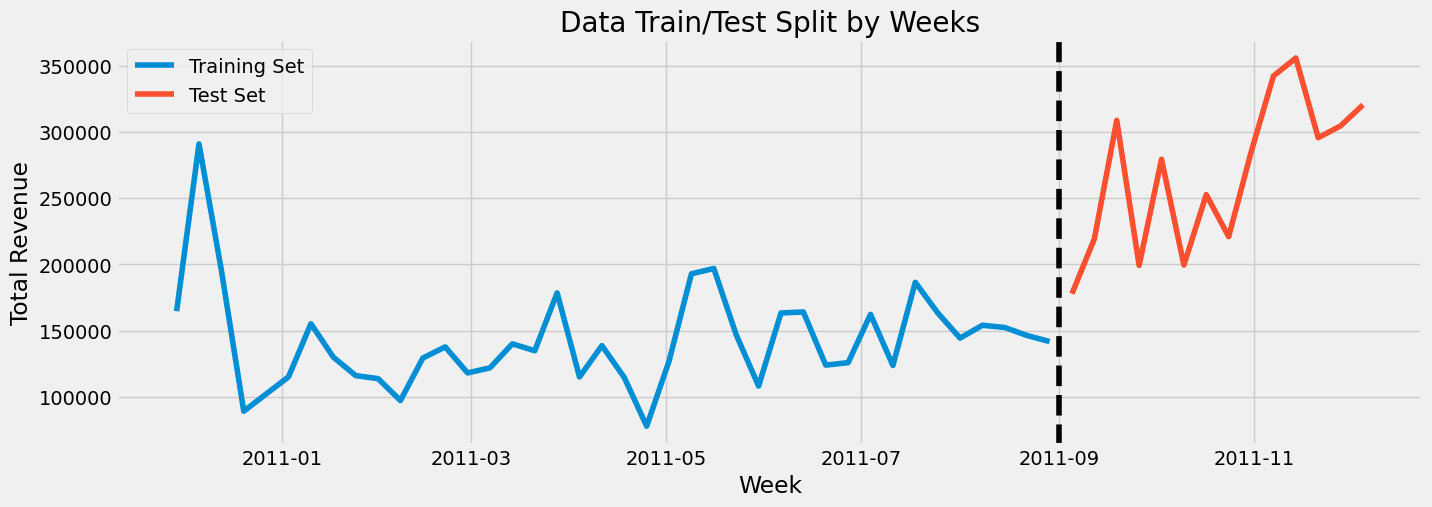

In [6]:
#Split Data

train = df.loc[df.index < '09-01-2011']
test = df.loc[df.index >= '09-01-2011']

fig, ax = plt.subplots(figsize=(15, 5))
train['revenue'].rolling(window=7).mean().plot(ax=ax, label='Training Set')
test['revenue'].rolling(window=7).mean().plot(ax=ax, label='Test Set')
ax.set_title('Data Train/Test')
ax.axvline('09-01-2011', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#Total Revenue by Day

train1 = daily_revenue_df.loc[pd.to_datetime(daily_revenue_df['days']) < '09-01-2011']
test1 = daily_revenue_df.loc[pd.to_datetime(daily_revenue_df['days']) >= '09-01-2011']

fig, ax = plt.subplots(figsize=(15, 5))

daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

ax.plot(train1['days'], train1['revenue'], label='Training Set')
ax.plot(test1['days'], test1['revenue'], label='Test Set')

ax.axvline(pd.to_datetime('09-01-2011'), color='black', ls='--')

ax.set_title('Data Train/Test Split by Days')
ax.legend()
plt.show()


split_date = pd.to_datetime('2011-09-01')

train2 = weekly_revenue_df[weekly_revenue_df['week'] < split_date]
test2 = weekly_revenue_df[weekly_revenue_df['week'] >= split_date]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(train2['week'], train2['revenue'], label='Training Set')
ax.plot(test2['week'], test2['revenue'], label='Test Set')

ax.axvline(split_date, color='black', linestyle='--')

ax.set_title('Data Train/Test Split by Weeks')
ax.set_xlabel('Week')
ax.set_ylabel('Total Revenue')
ax.legend()
plt.grid(True)
plt.show()


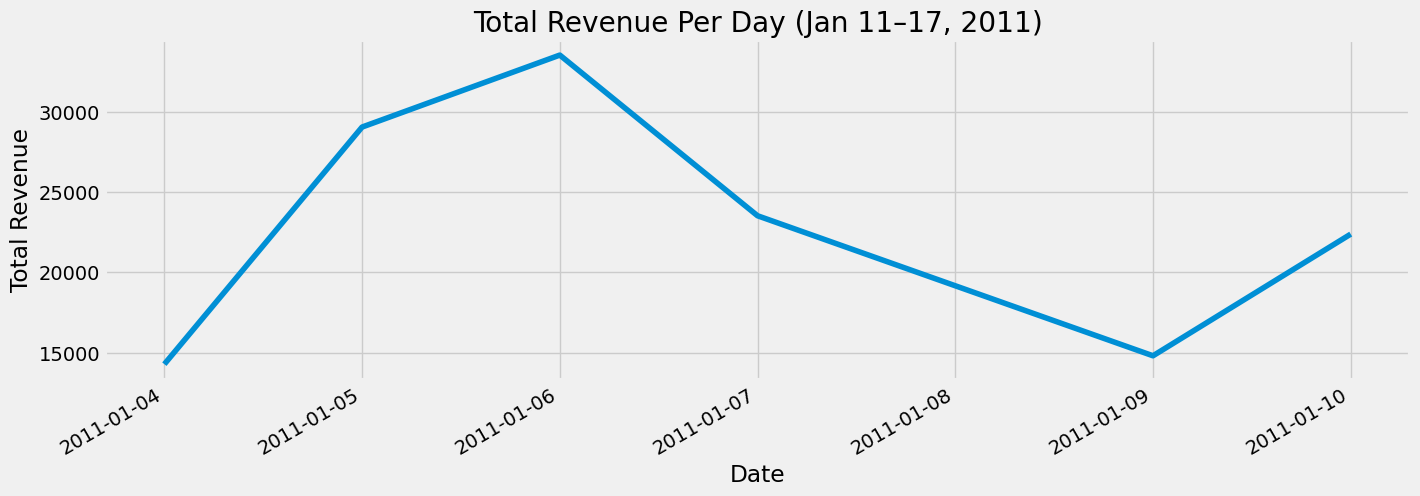

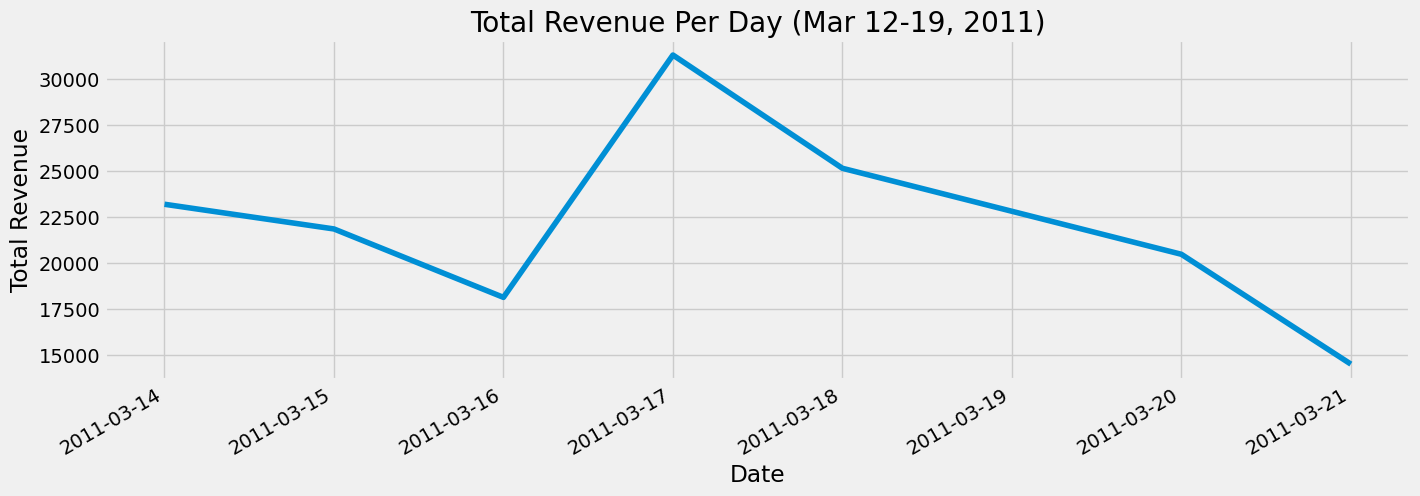

In [7]:
#Total revenue in a week
daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

week_df = daily_revenue_df[
    (daily_revenue_df['days'] >= '2011-01-3') & 
    (daily_revenue_df['days'] <= '2011-01-10')
]

week2_df = daily_revenue_df[
    (daily_revenue_df['days'] >= '2011-03-14') & 
    (daily_revenue_df['days'] <= '2011-03-21')
]

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_totals = week_df.groupby('days')['revenue'].sum()
daily_totals2 = week2_df.groupby('days')['revenue'].sum()

daily_totals.plot(figsize=(15, 5), title='Total Revenue Per Day (Jan 11–17, 2011)')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

daily_totals2.plot(figsize=(15, 5), title='Total Revenue Per Day (Mar 12-19, 2011)')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()


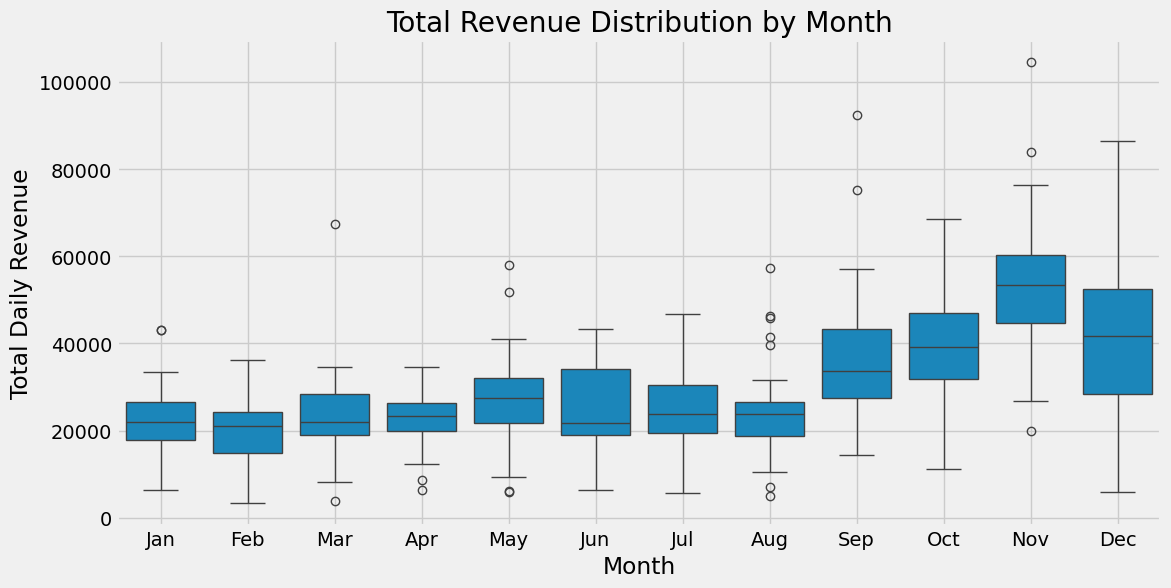

In [8]:
# Ensure 'days' is in datetime format
daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

# Add a 'month' column (name or number+name)
daily_revenue_df['month'] = daily_revenue_df['days'].dt.strftime('%b')  # 'Jan', 'Feb', etc.
daily_revenue_df['month_num'] = daily_revenue_df['days'].dt.month       # numeric to help order

# Group by day first to get total daily revenue
daily_totals = daily_revenue_df.groupby(['days', 'month', 'month_num'])['revenue'].sum().reset_index()

# Sort by month number to ensure correct order
daily_totals = daily_totals.sort_values(by='month_num')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=daily_totals, x='month', y='revenue', ax=ax)
ax.set_title('Total Revenue Distribution by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total Daily Revenue')
plt.grid(True)
plt.show()

In [48]:
#Set testing model
def create_features_model(df):
    df = df.copy()
    df['days'] =  pd.to_datetime(df['days'])
    df['dayofyear'] = df['days'].dt.dayofyear
    df['quarter'] = df['days'].dt.quarter
    df['is_weekend'] = df['days'].dt.dayofweek >= 5
    df['dayofweek'] = df['days'].dt.dayofweek
    df['hour'] = df['days'].dt.hour
    df['InvoiceDate'] = df['days']
    df['year'] = df['days'].dt.year
    df['quarter'] = df['days'].dt.quarter
    df['month'] = df['days'].dt.month
    return df

train = create_features_model(train1)
test = create_features_model(test1)

FEATURES = ['dayofyear', 'dayofweek', 'is_weekend', 'month', 'year', 
            'quarter']
TARGET = 'revenue'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [45]:
#Create Model

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:27612.96168	validation_1-rmse:48174.47744


[100]	validation_0-rmse:13140.13705	validation_1-rmse:32223.68975


C:\Users\rajit\AppData\Roaming\Python\Python312\site-packages\xgboost\callback.py:386: UserWarning: [12:06:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:9234.86551	validation_1-rmse:26443.89042
[300]	validation_0-rmse:8129.94015	validation_1-rmse:24423.67857
[400]	validation_0-rmse:7650.89825	validation_1-rmse:23624.03220
[500]	validation_0-rmse:7358.22549	validation_1-rmse:23352.23145
[600]	validation_0-rmse:7125.56301	validation_1-rmse:23287.90591
[700]	validation_0-rmse:6944.37842	validation_1-rmse:23265.74391
[770]	validation_0-rmse:6806.67014	validation_1-rmse:23279.85511


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

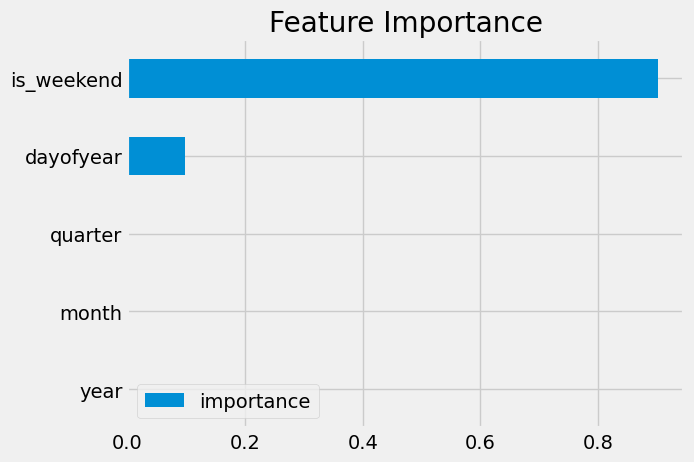

In [46]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

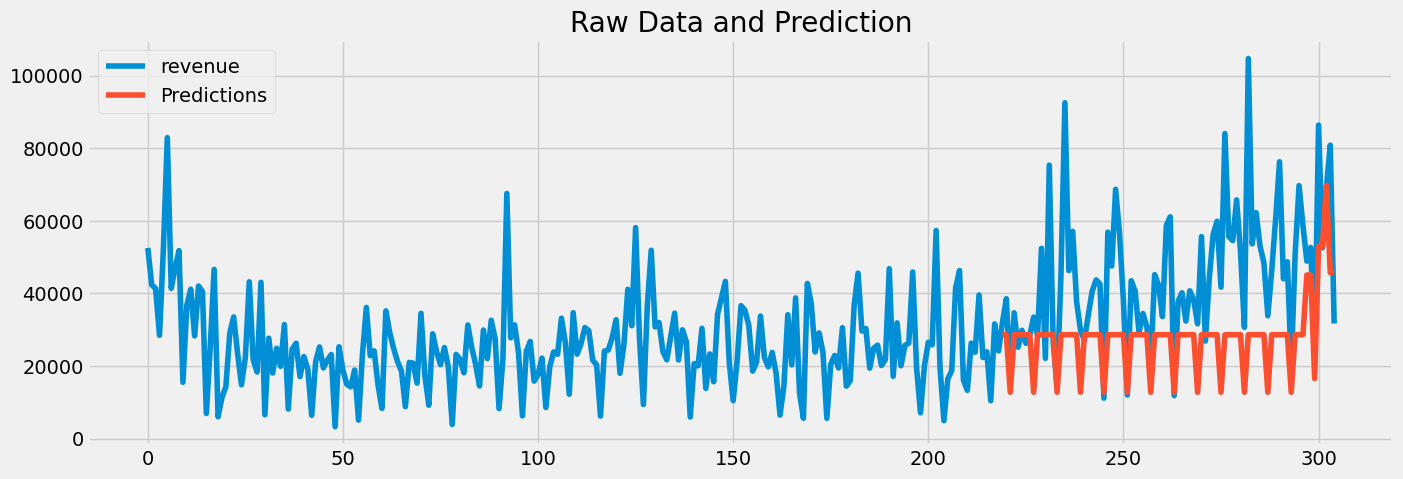

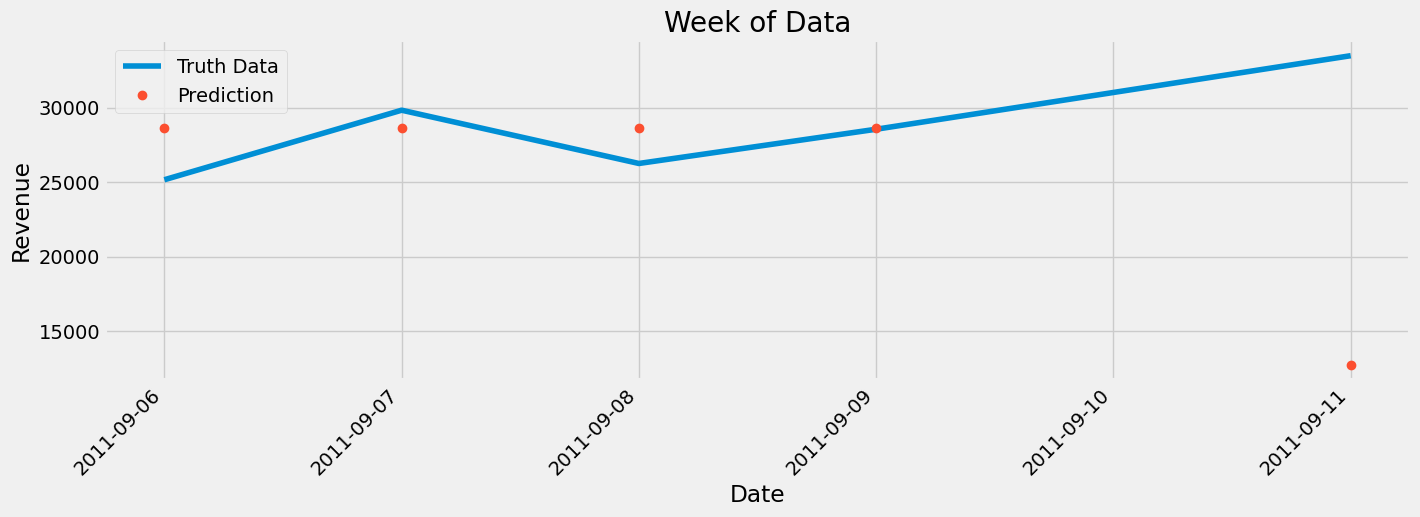

In [47]:
test['prediction'] = reg.predict(X_test)

test['days'] = pd.to_datetime(test1['days'])         
daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

if 'prediction' in daily_revenue_df.columns:
    daily_revenue_df = daily_revenue_df.drop(columns=['prediction'])

daily_revenue_df = daily_revenue_df.merge(
    test[['days', 'prediction']],
    on='days',
    how='left'
)

ax = daily_revenue_df[['revenue']].plot(figsize=(15, 5), label='Truth Data')
daily_revenue_df['prediction'].plot(ax=ax, label='Predictions')
plt.legend()
ax.set_title('Raw Data and Prediction')
plt.show()

mask = (daily_revenue_df['days'] > '2011-09-05') & (daily_revenue_df['days'] < '2011-09-12')
week_data = daily_revenue_df.loc[mask].copy()

week_data.set_index('days', inplace=True)

ax = week_data['revenue'].plot(figsize=(15, 5), label='Truth Data', title='Week of Data')
week_data['prediction'].plot(ax=ax, label='Prediction', style='o')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()


In [34]:
score = np.sqrt(mean_squared_error(test['revenue'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 22790.74


In [39]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test.groupby(['days'])['error'].mean().sort_values(ascending=False).head(10)

days
2011-11-14    78946.147734
2011-09-20    58688.958125
2011-11-07    58282.337734
2011-11-23    47740.514375
2011-09-15    42532.162500
2011-10-05    40128.414375
2011-10-21    35834.930078
2011-11-29    35833.248125
2011-11-04    34613.570078
2011-12-08    34298.021875
Name: error, dtype: float64